<a href="https://colab.research.google.com/github/DoggoWoofWoof/Implementation-of-GANDS/blob/main/CIFAR%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets.cifar10 import load_data
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU, UpSampling2D, Conv2D, Conv2DTranspose
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from numpy.random import rand, randn, randint
from numpy import ones, zeros
import tensorflow as tf
import imageio.v2 as imageio
import os

170498071/170498071 [==============================] - 4s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)
Enter the class numbers you want to display, separated by commas (e.g., 0,1,2) or 'all': all
Selected classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


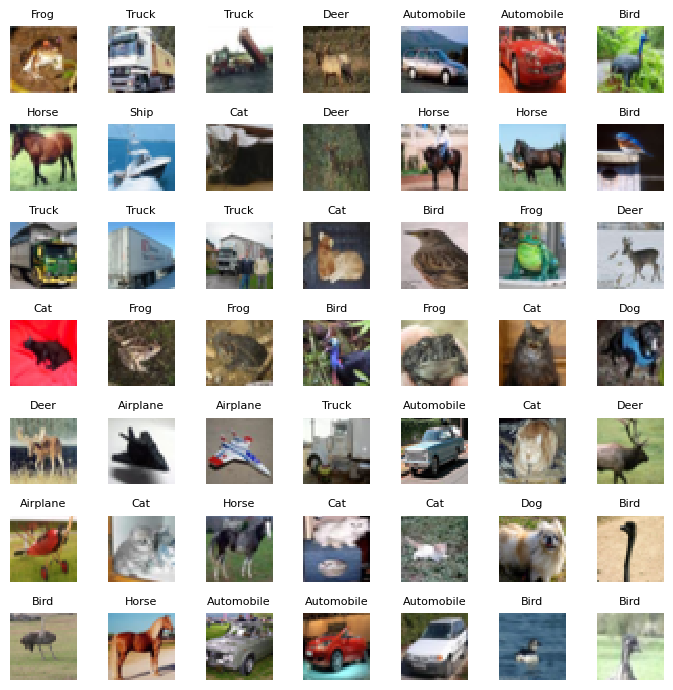

In [ ]:
# Load the CIFAR-10 dataset
(trainX, trainy), (testX, testy) = load_data()

n=7
in_shape=(32,32,3)
# set the seed for reproducibility
np.random.seed(42)
# define the size of the latent space
latent_dim = 100

# Print the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

# CIFAR-10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# User input for classes
selected_classes_input = input("Enter the class numbers you want to display, separated by commas (e.g., 0,1,2) or 'all': ")

if selected_classes_input.lower() == "all":
    selected_classes = list(range(10))
else:
    selected_classes = [int(x.strip()) for x in selected_classes_input.split(',')]

print("Selected classes:", selected_classes)

# Filter indices for selected classes
selected_indices = [i for i, label in enumerate(trainy) if label in selected_classes]

# Limit to the number of images to display
num_images = min(n*n, len(selected_indices))  # 10x10 grid, or fewer if not enough images

# Create a figure
fig, axes = plt.subplots(n, n, figsize=(n, n))

# Loop over the grid and plot images
for i, ax in enumerate(axes.flat):
    if i < num_images:
        idx = selected_indices[i]
        ax.imshow(trainX[idx], interpolation='nearest')
        label = class_names[trainy[idx][0]]
        ax.set_title(label, fontsize=8)
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Update trainX to only include selected classes
trainX = trainX[selected_indices]
trainy = trainy[selected_indices]

In [ ]:
# load and prepare cifar10 training images
def load_real_samples(trainX):
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [ ]:
# define the standalone discriminator model
def discriminator(in_shape):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = discriminator(in_shape)
# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

# How to Define and Use the Generator Model
The generator model is responsible for creating new, fake, but plausible small photographs of objects.

It does this by taking a point from the latent space as input and outputting a square color image.

The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, CIFAR-10 images, that only the generator knows how to turn into plausible CIFAR-10 images.

- Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- Outputs: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].

Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well.

# Latent space to image translation
Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 32 x 32 x 3, or 3,072 values.

There are a number of ways to achieve this, but there is one approach that has proven effective on deep convolutional generative adversarial networks. It involves two main elements.

1. The first is a __Dense__ layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 16x16x3, or 768 nodes, and an image one quarter the size (one eighth the area) would be 8 x 8 x 3, or 192 nodes.

With some experimentation, I have found that a smaller low-resolution version of the image works better. Therefore, we will use 4 x 4 x 3, or 48 nodes.

We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

Therefore, the first hidden layer, the Dense, needs enough nodes for multiple versions of our output image, such as 256.

The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 256 different 4 x 4 feature maps.

2. The next major architectural innovation involves __upsampling__ the low-resolution image to a higher resolution version of the image.

There are two common ways to do this upsampling process, sometimes called __deconvolution__.

One way is to use an __UpSampling2D__ layer (like a reverse pooling layer) followed by a normal Conv2D layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a __Conv2DTranspose__. _We will use this latter approach for our generator._

The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (_double their width and height dimensions_).

It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to __avoid a checkerboard pattern__ that can sometimes be observed when upsampling.

This can be repeated two more times to arrive at our required 32 x 32 output image.

Again, we will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.

The output layer of the model is a Conv2D with three filters for the three required channels and a kernel size of 3×3 and ‘same‘ padding, designed to create a single feature map and preserve its dimensions at 32 x 32 x 3 pixels. A tanh activation is used to ensure output values are in the desired range of [-1,1], a current best practice.

The define_generator() function below implements this and defines the generator model.

Note: the generator model is __not compiled__ and does not specify a loss function or optimization algorithm. __This is because the generator is not trained directly. We will learn more about this in the next section.__

In [ ]:
# define the standalone generator model
def generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the generator model
model = generator(latent_dim)
# summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                           

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# How to Train the Generator Model
The weights in the generator model are updated based on the performance of the discriminator model.

___When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.___

This defines the zero-sum or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a ___new model that combines the generator and discriminator models.___

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models.

Only the discriminator is concerned with distinguishing between real and fake examples, therefore ___the discriminator model can be trained in a standalone manner on examples of each, as we did in the section on the discriminator model above.___

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, ___we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.___

When training the generator via this logical GAN model, there is one more important change. ___We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).___

__Why would we want to do this?__

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights ___(i.e. only the weights in the generator)___ to correct for this error, in turn ___making the generator better at generating good fake samples.___

Let’s make this concrete.

- Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- Outputs: Binary classification, likelihood the sample is real (or fake).

The `define_gan()` function below takes as arguments the already-defined generator and discriminator models and creates the new, logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum of 0.5, recommended when training deep convolutional GANs.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# demonstrate creating the three models in the gan
# create the discriminator
d_model = discriminator(in_shape)
# create the generator
g_model = generator(latent_dim)
# create the gan
gan_model = gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


In [ ]:
def create_plot(examples, filename, n):
    """Creates and saves a plot of images using a fixed grid size of nxn."""
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0

    # plot images
    plt.figure(figsize=(n, n))  # Adjust figure size as needed
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])

    # show the plot
    plt.show()

    # save plot to file
    plt.savefig(filename)
    plt.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

    # Save the generator model
    filename = f'generator_model_{epoch+1:03d}.h5'
    g_model.save(filename)

In [ ]:
# Function to save real and fake images for a given epoch
def save_images(iepoch, jepoch, X_real, X_fake):
    """Saves plots of real and fake images for a given epoch using a fixed grid size."""
    # Create the epoch identifier string
    epoch_str = f"{iepoch}_{jepoch}"

    # Create directory to save images
    save_dir = 'generated_images'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Plot and save real images
    real_filename = os.path.join(save_dir, f"real_images_epoch_{epoch_str}.png")
    create_plot(X_real, real_filename, n)

    # Plot and save fake images
    fake_filename = os.path.join(save_dir, f"fake_images_epoch_{epoch_str}.png")
    create_plot(X_fake, fake_filename, n)


In [ ]:
def create_gif(image_folder, output_filename, prefix):
    """Creates a GIF from images with the given prefix in the specified folder."""
    # Get all image file paths with the specified prefix
    images = []
    for filename in sorted(os.listdir(image_folder)):
        if filename.startswith(prefix) and filename.endswith(".png"):
            images.append(imageio.imread(os.path.join(image_folder, filename)))

    # Save the images as a GIF
    imageio.mimsave(output_filename, images, fps=2)

In [ ]:
# Training the GAN
def train(g_model, d_model, gan_model, dataset, latent_dim, display_interval, n_epochs=200, n_batch=128, n_samples=200):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(1,n_epochs+1):
        for j in range(1,bat_per_epo+1):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print(f">{i+1}, {j+1}/{bat_per_epo}, d1={d_loss1:.3f}, d2={d_loss2:.3f} g={g_loss:.3f}")
            if (j) % 200 == 0:
                # Generate images every 200 batches per epochs without summarizing
                X_real,_= generate_real_samples(dataset, n_samples)
                X_fake,_ = generate_fake_samples(g_model, latent_dim, n_samples)
                # Save images
                save_images(i,j, X_real,X_fake)
        if (i) % 10 == 0:
            # Summarize every 10 epochs
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

display_interval=10
# create the discriminator
d_model = discriminator(in_shape)
# create the generator
g_model = generator(latent_dim)
# create the gan
gan_model = gan(g_model, d_model)
# load image data
dataset = load_real_samples(trainX)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, display_interval)

2/2 [==============================] - 0s 34ms/step
>1, 1/390, d1=0.669, d2=0.696 g=0.691
2/2 [==============================] - 0s 35ms/step
>1, 2/390, d1=0.613, d2=0.700 g=0.687
2/2 [==============================] - 0s 4ms/step
>1, 3/390, d1=0.532, d2=0.712 g=0.676
2/2 [==============================] - 0s 3ms/step
>1, 4/390, d1=0.445, d2=0.739 g=0.652
2/2 [==============================] - 0s 4ms/step
>1, 5/390, d1=0.321, d2=0.798 g=0.612
2/2 [==============================] - 0s 3ms/step
>1, 6/390, d1=0.241, d2=0.889 g=0.573
2/2 [==============================] - 0s 4ms/step
>1, 7/390, d1=0.181, d2=0.946 g=0.578
2/2 [==============================] - 0s 4ms/step
>1, 8/390, d1=0.168, d2=0.891 g=0.643
2/2 [==============================] - 0s 4ms/step
>1, 9/390, d1=0.172, d2=0.754 g=0.769
2/2 [==============================] - 0s 4ms/step
>1, 10/390, d1=0.173, d2=0.615 g=0.924
2/2 [==============================] - 0s 4ms/step
>1, 11/390, d1=0.167, d2=0.537 g=0.999
2/2 [============

Streaming output truncated to the last 5000 lines.
>5, 244/390, d1=0.424, d2=0.580 g=1.214
2/2 [==============================] - 0s 4ms/step
>5, 245/390, d1=0.591, d2=0.637 g=1.046
2/2 [==============================] - 0s 3ms/step
>5, 246/390, d1=0.627, d2=0.668 g=0.959
2/2 [==============================] - 0s 5ms/step
>5, 247/390, d1=0.537, d2=0.798 g=1.004
2/2 [==============================] - 0s 4ms/step
>5, 248/390, d1=0.422, d2=0.661 g=1.072
2/2 [==============================] - 0s 4ms/step
>5, 249/390, d1=0.516, d2=0.578 g=1.189
2/2 [==============================] - 0s 5ms/step
>5, 250/390, d1=0.450, d2=0.429 g=1.251
2/2 [==============================] - 0s 4ms/step
>5, 251/390, d1=0.285, d2=0.461 g=1.362
2/2 [==============================] - 0s 4ms/step
>5, 252/390, d1=0.341, d2=0.449 g=1.292
2/2 [==============================] - 0s 6ms/step
>5, 253/390, d1=0.376, d2=0.608 g=1.413
2/2 [==============================] - 0s 4ms/step
>5, 254/390, d1=0.312, d2=0.556 g=1.445

Streaming output truncated to the last 5000 lines.
>15, 244/390, d1=0.767, d2=0.813 g=0.822
2/2 [==============================] - 0s 3ms/step
>15, 245/390, d1=0.711, d2=0.678 g=0.965
2/2 [==============================] - 0s 3ms/step
>15, 246/390, d1=0.780, d2=0.545 g=1.072
2/2 [==============================] - 0s 4ms/step
>15, 247/390, d1=0.768, d2=0.550 g=0.931
2/2 [==============================] - 0s 4ms/step
>15, 248/390, d1=0.710, d2=0.611 g=0.885
2/2 [==============================] - 0s 5ms/step
>15, 249/390, d1=0.677, d2=0.607 g=0.901
2/2 [==============================] - 0s 3ms/step
>15, 250/390, d1=0.606, d2=0.647 g=0.924
2/2 [==============================] - 0s 3ms/step
>15, 251/390, d1=0.627, d2=0.657 g=0.858
2/2 [==============================] - 0s 4ms/step
>15, 252/390, d1=0.633, d2=0.734 g=0.743
2/2 [==============================] - 0s 3ms/step
>15, 253/390, d1=0.621, d2=0.813 g=0.735
2/2 [==============================] - 0s 3ms/step
>15, 254/390, d1=0.624, d2=0.

>Accuracy real: 48%, fake: 78%
2/2 [==============================] - 0s 3ms/step
>22, 1/390, d1=0.660, d2=0.672 g=0.855
2/2 [==============================] - 0s 9ms/step
>22, 2/390, d1=0.631, d2=0.743 g=0.833
2/2 [==============================] - 0s 4ms/step
>22, 3/390, d1=0.675, d2=0.625 g=0.875
2/2 [==============================] - 0s 5ms/step
>22, 4/390, d1=0.739, d2=0.621 g=0.865
2/2 [==============================] - 0s 3ms/step
>22, 5/390, d1=0.706, d2=0.586 g=0.874
2/2 [==============================] - 0s 3ms/step
>22, 6/390, d1=0.695, d2=0.619 g=0.856
2/2 [==============================] - 0s 4ms/step
>22, 7/390, d1=0.705, d2=0.647 g=0.836
2/2 [==============================] - 0s 3ms/step
>22, 8/390, d1=0.619, d2=0.635 g=0.793
2/2 [==============================] - 0s 6ms/step
>22, 9/390, d1=0.632, d2=0.706 g=0.799
2/2 [==============================] - 0s 4ms/step
>22, 10/390, d1=0.624, d2=0.782 g=0.834
2/2 [==============================] - 0s 4ms/step
>22, 11/390, d1=0

In [ ]:
# After training is complete, create the GIFs
create_gif('generated_images', 'fake_training_progress.gif', 'fake_images')
create_gif('generated_images', 'real_training_progress.gif', 'real_images')

4/4 [==============================] - 1s 128ms/step


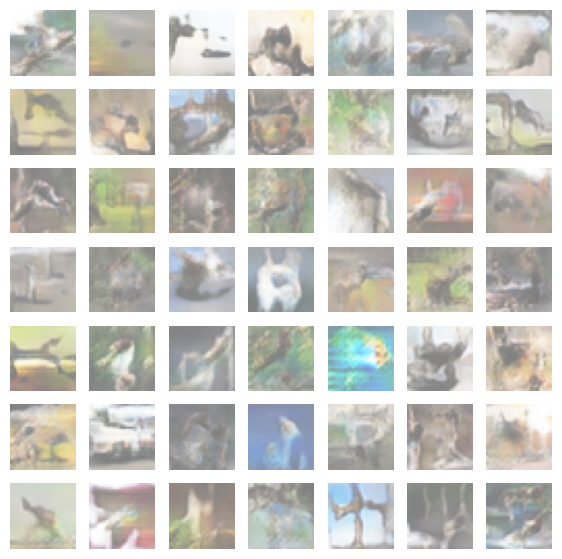

In [ ]:
# example of loading the generator model and generating images
# Load model
# model = load_model('generator_model_200.h5')
model = load_model('generator_model_031.h5')

# Generate images
np.random.seed(69)
latent_points = generate_latent_points(latent_dim, latent_dim)
X = model.predict(latent_points)

# Scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# Plot the results
create_plot(X, 'generated_images.png',7)